In [14]:
import numpy as np
import my_code.diffusion_training_sign_corr.data_loading as data_loading
import yaml
from tqdm import tqdm
import metrics.geodist_metric as geodist_metric
from utils.shape_util import compute_geodesic_distmat
import torch


dataset_name = 'DT4D_inter_pair'

single_dataset, pair_dataset = data_loading.get_val_dataset(
    dataset_name, 'test', 128, preload=False, return_evecs=True, centering='bbox'
)


# Data generation

In [9]:
import os

for file in tqdm(single_dataset.off_files):
    # copy the file to /home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/DT4D_r/shapes_test
    
    os.system(f'cp {file} /home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/DT4D_r/shapes_test')
        

In [10]:
import os

for file in tqdm(single_dataset.corr_files):
    # copy the file to /home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/DT4D_r/shapes_test
    
    os.system(f'cp {file} /home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/DT4D_r/corres')
   

In [12]:
# get the size of this file in Mb
# /home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/results/DT4D_FS/p2p_21/BrooklynUprock134_BrooklynUprock134.txt

import os

file_path = '/home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/results/DT4D_FS/p2p_21/BrooklynUprock134_BrooklynUprock134.txt'

size = os.path.getsize(file_path) / (1024 * 1024)

print(size * 7000*2 / 1024)

# Test

In [5]:
dist_mat_list = []

for i in tqdm(range(len(single_dataset))):

    data_i = single_dataset[i]

    dist_mat = torch.tensor(
        compute_geodesic_distmat(data_i['verts'].numpy(), data_i['faces'].numpy())    
    )
    
    dist_mat_list.append(dist_mat)

In [15]:
categories = []

for file in single_dataset.off_files:
    categories.append(file.split('/')[-2])
    
categories = list(set(categories))
print(categories)



In [19]:

path = f'/home/s94zalek_hpc/baselines/Spatially-and-Spectrally-Consistent-Deep-Functional-Maps/data/results/DT4D_FS/p2p_21'

err_by_category = {category: 0 for category in categories}
times_by_category = {category: 0 for category in categories}

geo_err_list = []

for i in tqdm(range(len(pair_dataset))):
    
    data_i = pair_dataset[i]
    
    first_idx = data_i['first']['id']
    second_idx = data_i['second']['id']
    
    # print(first_idx, second_idx)
    
    off_first = single_dataset.off_files[first_idx]
    name_first = off_first.split('/')[-1].split('.')[0]
    
    off_second = single_dataset.off_files[second_idx]
    name_second = off_second.split('/')[-1].split('.')[0]
    
    # print(name_first, name_second)
    
    # break    
    
    
    p2p = torch.tensor(
        np.loadtxt(f'{path}/{name_first}_{name_second}.txt')
    ).int()
    
    dist_x = dist_mat_list[first_idx]
    dist_y = dist_mat_list[second_idx]
    
    corr_first = data_i['first']['corr']
    corr_second = data_i['second']['corr']
    
    geo_err = geodist_metric.calculate_geodesic_error(
        dist_x, corr_first.cpu(), corr_second.cpu(), p2p, return_mean=True
    ) * 100
    geo_err_list.append(geo_err)


    category_first = (single_dataset.off_files[int(first_idx)]).split('/')[-2]
    category_second = (single_dataset.off_files[int(second_idx)]).split('/')[-2]
            
            # if 'hippo' in category_first or 'hippo' in category_second:
            #     continue
            
    err_by_category[category_first] += float(geo_err)
    err_by_category[category_second] += float(geo_err)
    
    times_by_category[category_first] += 1
    times_by_category[category_second] += 1
            

    
geo_err_list = torch.tensor(geo_err_list)
print(f'{dataset_name}, mean geo err: {geo_err_list.mean()}, median: {geo_err_list.median()}')

for category in categories:
    err_by_category[category] /= times_by_category[category] if times_by_category[category] > 0 else 1
       

In [20]:
err_by_category_list = sorted(
    [(k, v) for k, v in err_by_category.items()],
    key=lambda x: x[1], reverse=False
)
categories_sorted = [entry[0] for entry in err_by_category_list]

for category in categories_sorted:
    print(f'{category}: {err_by_category[category]:.2f} ({times_by_category[category]})')

F on intra

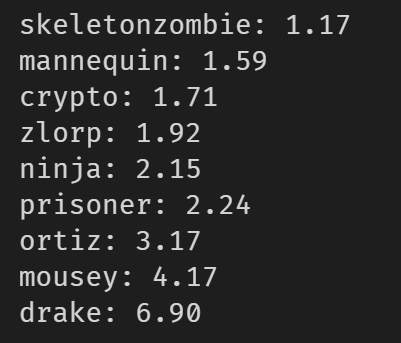

F+S on intra

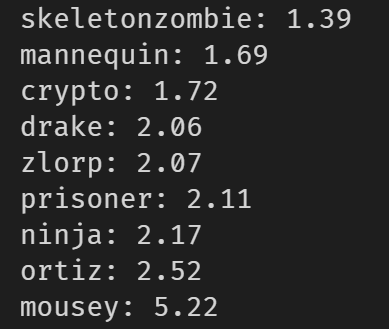

F on inter

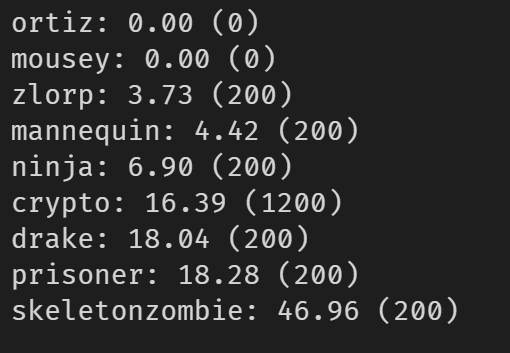

F+S on inter

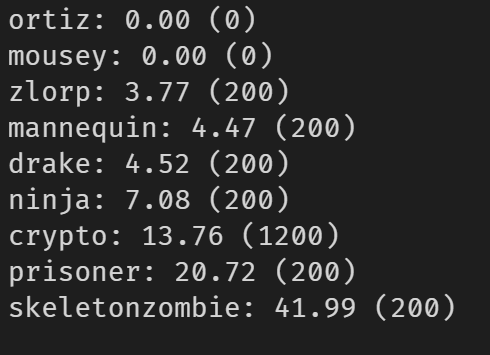